In [1]:
!pip install ipywidgets



In [5]:
!pip install numpy matplotlib scipy


In [6]:
!jupyter nbextension enable --py widgetsnbextension


Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: ok


## Static 3D Visualization of Black Hole Radiation Spectrum ##


C:\Users\jhaki\AppData\Local\Temp\ipykernel_20080\1570179761.py:25: RuntimeWarning: overflow encountered in exp
  exp_term = np.exp(h_over_kT * self.frequencies)


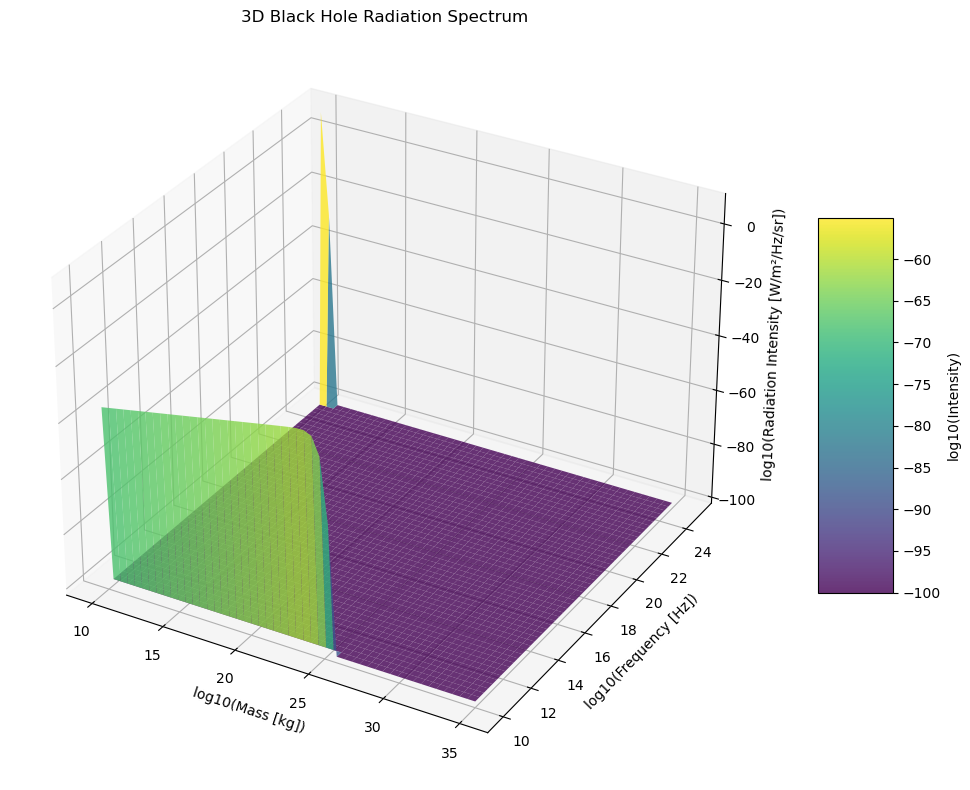


## Interactive 3D View (Use Sliders to Rotate) ##


interactive(children=(FloatSlider(value=30.0, description='Elevation:', max=90.0, min=10.0, step=5.0), FloatSl…

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from ipywidgets import interact, FloatSlider
from scipy.constants import h, c, G, k, sigma

# Constants
M_sun = 1.98847e30  # Solar mass in kg

class BlackHole3D:
    def __init__(self, mass):
        self.mass = mass
        self.update_properties()
    
    def update_properties(self):
        # Schwarzschild radius (m)
        self.radius = 2 * G * self.mass / c**2
        
        # Hawking temperature (K)
        self.temperature = (h * c**3) / (16 * np.pi**2 * k * G * self.mass)
        
        # Radiation spectrum calculation
        self.frequencies = np.logspace(10, 25, 100)  # 10 GHz to 10 YHz
        h_over_kT = h / (k * self.temperature)
        exp_term = np.exp(h_over_kT * self.frequencies)
        self.spectrum = (2 * h * self.frequencies**3 / c**2) / (exp_term - 1)
        
        # Apply gray-body factor approximation
        gray_factor = 27 * (G * self.mass * self.frequencies / c**3)**2
        self.spectrum *= gray_factor

def create_3d_plot():
    # Create mass range (from microscopic to stellar black holes)
    masses = np.logspace(10, 35, 50)  # 10^10 kg to 10^35 kg
    
    # Prepare data for 3D plot
    X, Y = np.meshgrid(masses, np.logspace(10, 25, 50))
    Z = np.zeros_like(X)
    
    for i, mass in enumerate(masses):
        bh = BlackHole3D(mass)
        for j, freq in enumerate(bh.frequencies):
            if freq in Y[:,0]:
                k = np.where(Y[:,0] == freq)[0][0]
                Z[k,i] = bh.spectrum[j]
    
    # Create figure
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot surface
    surf = ax.plot_surface(np.log10(X), np.log10(Y), np.log10(Z+1e-100), 
                         cmap='viridis', edgecolor='none', alpha=0.8)
    
    # Customize axes
    ax.set_xlabel('log10(Mass [kg])')
    ax.set_ylabel('log10(Frequency [Hz])')
    ax.set_zlabel('log10(Radiation Intensity [W/m²/Hz/sr])')
    ax.set_title('3D Black Hole Radiation Spectrum')
    
    # Add colorbar
    fig.colorbar(surf, shrink=0.5, aspect=5, label='log10(Intensity)')
    
    plt.tight_layout()
    plt.show()

def interactive_3d_view():
    @interact(
        elevation=FloatSlider(min=10, max=90, step=5, value=30, description='Elevation:'),
        azimuth=FloatSlider(min=0, max=360, step=5, value=45, description='Azimuth:')
    )
    def update_view(elevation=30, azimuth=45):
        # Create mass range
        masses = np.logspace(10, 35, 50)
        
        # Prepare data
        X, Y = np.meshgrid(masses, np.logspace(10, 25, 50))
        Z = np.zeros_like(X)
        
        for i, mass in enumerate(masses):
            bh = BlackHole3D(mass)
            for j, freq in enumerate(bh.frequencies):
                if freq in Y[:,0]:
                    k = np.where(Y[:,0] == freq)[0][0]
                    Z[k,i] = bh.spectrum[j]
        
        # Create figure
        fig = plt.figure(figsize=(12, 8))
        ax = fig.add_subplot(111, projection='3d')
        
        # Plot surface
        surf = ax.plot_surface(np.log10(X), np.log10(Y), np.log10(Z+1e-100), 
                             cmap='plasma', edgecolor='none', alpha=0.8)
        
        # Set viewing angle
        ax.view_init(elev=elevation, azim=azimuth)
        
        # Labels
        ax.set_xlabel('log10(Mass [kg])')
        ax.set_ylabel('log10(Frequency [Hz])')
        ax.set_zlabel('log10(Radiation Intensity)')
        ax.set_title(f'3D Black Hole Radiation (Elev: {elevation}°, Azim: {azimuth}°)')
        
        plt.colorbar(surf, shrink=0.5, aspect=5)
        plt.tight_layout()
        plt.show()

# Run the visualizations
print("## Static 3D Visualization of Black Hole Radiation Spectrum ##")
create_3d_plot()

print("\n## Interactive 3D View (Use Sliders to Rotate) ##")
interactive_3d_view()

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb
from ipywidgets import interact, FloatSlider
from scipy.constants import c, G, h, k

# Initialize with matplotlib inline (works everywhere)
%matplotlib inline  

M_sun = 1.98847e30  # Solar mass in kg

class BlackHoleVisualizer:
    def __init__(self, mass=1e31):  # ~5 solar masses
        self.mass = mass
        self.rs = 2 * G * mass / c**2  # Schwarzschild radius
        
    def gravitational_lensing(self, x, y):
        """Simulate light bending near event horizon"""
        r = np.sqrt(x**2 + y**2)
        distortion = np.where(r > self.rs, self.rs**2 / r**2, np.inf)
        return x * (1 - distortion), y * (1 - distortion)
    
    def plot(self):
        # Create accretion disk
        resolution = 300
        x = np.linspace(-5*self.rs, 5*self.rs, resolution)
        y = np.linspace(-5*self.rs, 5*self.rs, resolution)
        X, Y = np.meshgrid(x, y)
        
        # Apply lensing effect
        X_dist, Y_dist = self.gravitational_lensing(X, Y)
        R = np.sqrt(X_dist**2 + Y_dist**2)
        
        # Temperature profile (hotter near the center)
        T = 1e6 * (self.rs / (R + 0.3*self.rs))  # Kelvin
        
        # Convert to color (blue=hot, red=cool)
        hue = np.clip(np.log10(T + 1e3) / 8, 0, 1)
        sat = np.where((R > 1.5*self.rs) & (R < 4*self.rs), 1.0, 0.3)
        val = np.exp(-(R - 2*self.rs)**2/(2*self.rs**2))
        rgb = hsv_to_rgb(np.dstack((hue, sat, val)))
        
        # Add black hole shadow
        rgb[R < 1.5*self.rs] = 0
        
        # Plot
        fig, ax = plt.subplots(figsize=(8, 8), facecolor='black')
        ax.imshow(rgb, extent=[x.min(), x.max(), y.min(), y.max()], origin='lower')
        ax.set_title(f'{self.mass/M_sun:.1f} Solar Mass Black Hole\n'
                    f'Event Horizon: {self.rs/1000:.1f} km', 
                    color='white')
        ax.axis('off')
        plt.show()

# Interactive version (will show sliders if widgets work)
def interactive_black_hole(mass_solar=5.0):
    visualizer = BlackHoleVisualizer(mass_solar * M_sun)
    visualizer.plot()

# Try with interact (comment out if widgets don't work)
try:
    interact(interactive_black_hole, 
             mass_solar=FloatSlider(min=0.1, max=50, step=0.1, value=5.0))
except:
    print("Widgets not available - displaying static plot instead")
    interactive_black_hole(5.0)  # Fallback to static plot

interactive(children=(FloatSlider(value=5.0, description='mass_solar', max=50.0, min=0.1), Output()), _dom_cla…